## Shared Bike Demand Prediction Case Study

### Importing and Understanding Data

In [3]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange,uniform
from sklearn.metrics import r2_score
from scipy import stats

In [5]:
# Load Data
Data_Day = pd.read_csv("day.csv")

In [6]:
Data_Day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# EDA

In [8]:
#Check Type of DataFrame
print(type(Data_Day))

<class 'pandas.core.frame.DataFrame'>


In [9]:
#Data Types of Varaibles

print(Data_Day.dtypes)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


In [10]:
#Dimension
print(Data_Day.shape)

(730, 16)


In [11]:
# Index range

print(Data_Day.index)

RangeIndex(start=0, stop=730, step=1)


In [12]:
#columns 

print(Data_Day.columns)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


In [13]:
#unique values present in each variable

print(Data_Day.nunique())

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64


In [14]:
# variable "instant" can be dropped as it simply represents the index
# Variable "dteday" can be ignored as output is not based on time series analysis
# casual and registered variables can be removed, as these two sums to dependent variable count

Data_Day = Data_Day.drop(Data_Day.columns[[0, 1, 13, 14]], axis = "columns")

print(Data_Day.shape)

(730, 12)


In [15]:
#Defining numeric and categorical variables and saving in specific array

numeric_var = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

categorical_var = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

### Data Preparation

#### Handle missing values:

Check for missing values using Data_Day.isnull().sum(). You can handle missing values by imputing them (filling them in with a strategy), or dropping rows/columns with missing values.

In [18]:
#sum of missing values 

Data_Day.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

### No missing values found

## Outlier Analysis

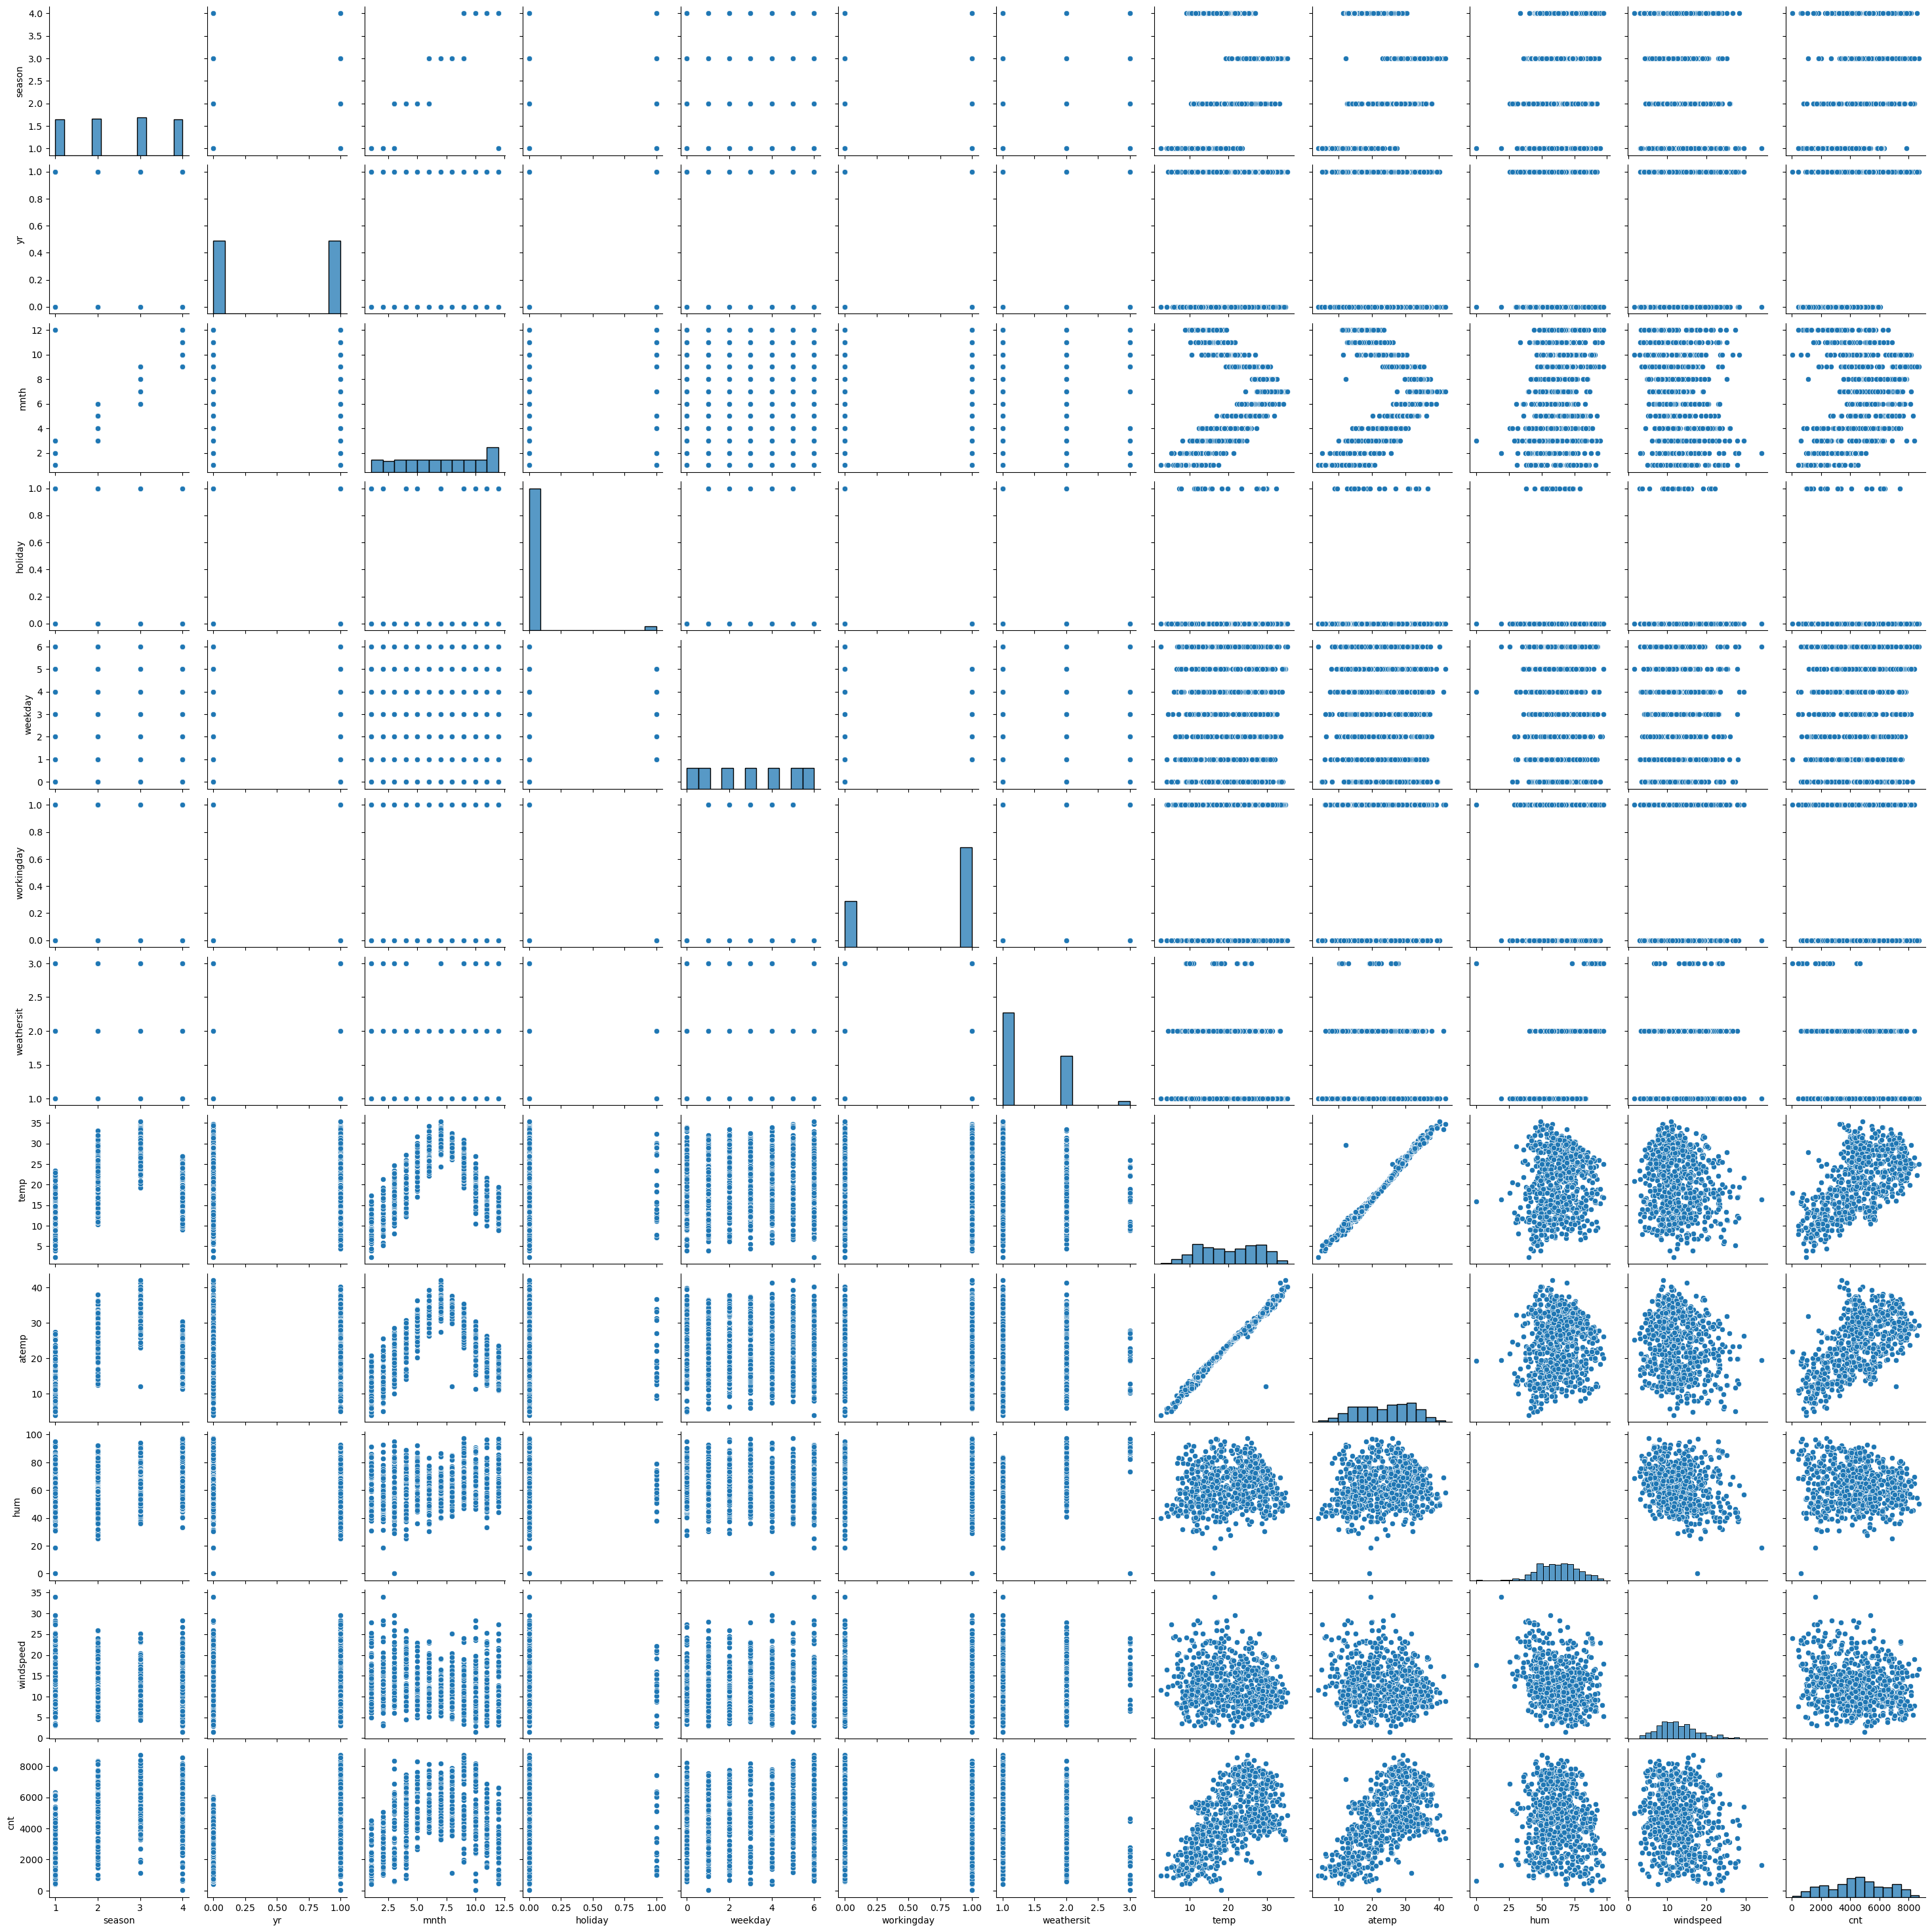

In [21]:
sns.pairplot(Data_Day)
plt.show()

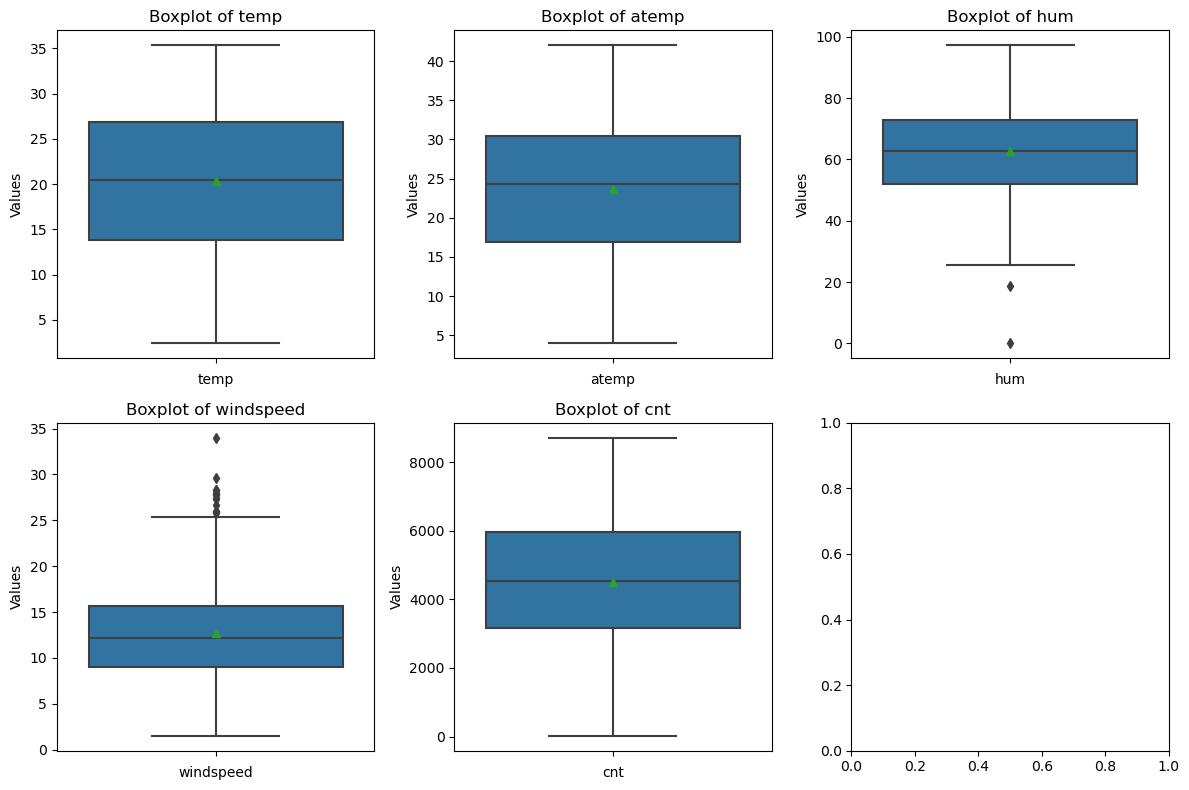

In [22]:

# Create a 2x3 grid layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjust figsize for readability

# Iterate through numeric variables and create boxplots
for i, var in enumerate(numeric_var):
    row = i // 3  # Integer division for efficient grid placement
    col = i % 3

    # Create boxplots on subplots in the grid
    sns.boxplot(ax=axes[row, col], y=Data_Day[var], showmeans=True)  # Include mean markers
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel("Values")
    axes[row, col].set_title("Boxplot of " + var)

# Adjust layout (optional, customize as needed)
plt.tight_layout()

# Display the grid of boxplots
plt.show()    

### outliers are found in windspeed and humidity variables.

In [24]:
# Identify outliers
#calculate Inner Fence, Outer Fence, and IQR
def identify_and_replace_outliers(data_frame, numeric_columns):
  """
  Identifies and replaces outliers in a DataFrame for specified numeric columns.

  Args:
      data_frame (pandas.DataFrame): The DataFrame containing the data.
      numeric_columns (list): A list containing names of numerical columns.

  Returns:
      pandas.DataFrame: The DataFrame with outliers replaced by NaN.
  """

  for col in numeric_columns:
    # Calculate quartiles and IQR
    q75, q25 = np.percentile(data_frame.loc[:, col], [75, 25])
    iqr = q75 - q25

    # Calculate inner and outer fences
    inner_fence = q25 - (1.5 * iqr)
    upper_fence = q75 + (1.5 * iqr)

    # Print information (optional)
    print(f"Column: {col}")
    print(f"Inner Fence: {inner_fence:.2f}")  # Format for readability
    print(f"Upper Fence: {upper_fence:.2f}")
    print(f"IQR: {iqr:.2f}")

    # Replace outliers with NaN
    data_frame.loc[data_frame[col] < inner_fence, col] = np.nan
    data_frame.loc[data_frame[col] > upper_fence, col] = np.nan

  return data_frame

# Apply the function to identify and replace outliers
day = identify_and_replace_outliers(Data_Day.copy(), numeric_var)

Column: temp
Inner Fence: -5.79
Upper Fence: 46.48
IQR: 13.07
Column: atemp
Inner Fence: -3.44
Upper Fence: 50.78
IQR: 13.56
Column: hum
Inner Fence: 20.52
Upper Fence: 104.47
IQR: 20.99
Column: windspeed
Inner Fence: -0.83
Upper Fence: 25.50
IQR: 6.58
Column: cnt
Inner Fence: -1024.62
Upper Fence: 10160.38
IQR: 2796.25


In [25]:
Data_Day.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [26]:
# total 15 outliers found. Now, impute the values, by the help of median.

Data_Day['hum'] = Data_Day['hum'].fillna(Data_Day['hum'].median())
Data_Day['windspeed'] = Data_Day['windspeed'].fillna(Data_Day['windspeed'].median())

In [27]:
# Check NA Values

Data_Day.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

## DATA UNDERSTANDING

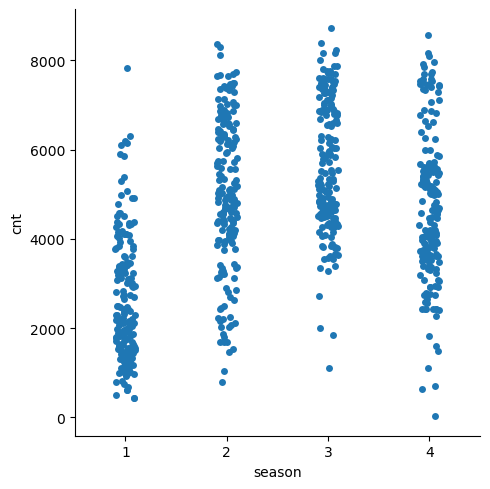

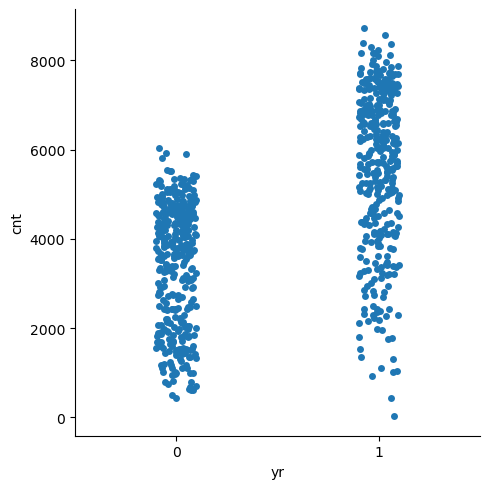

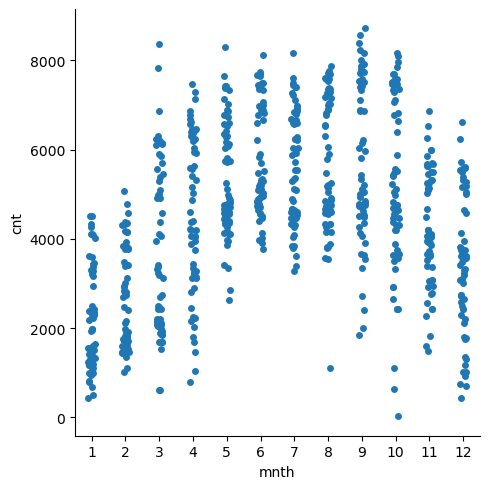

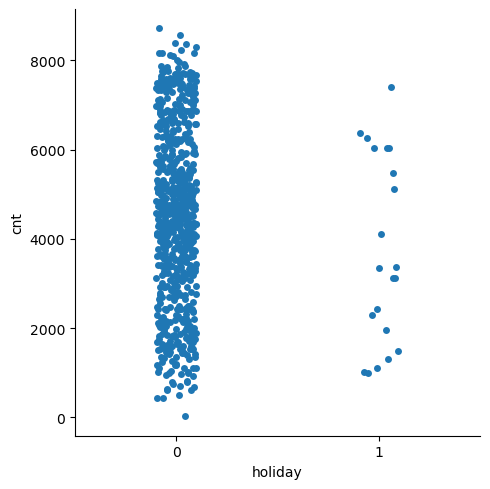

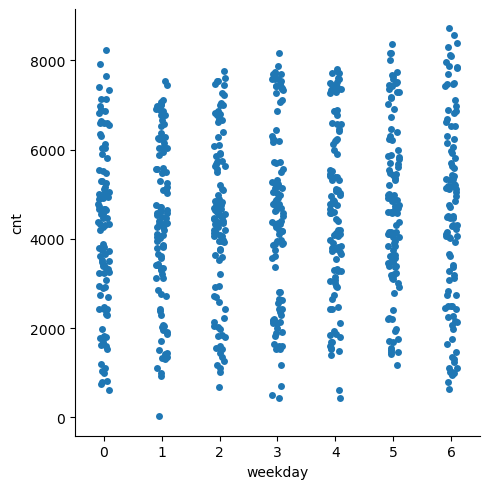

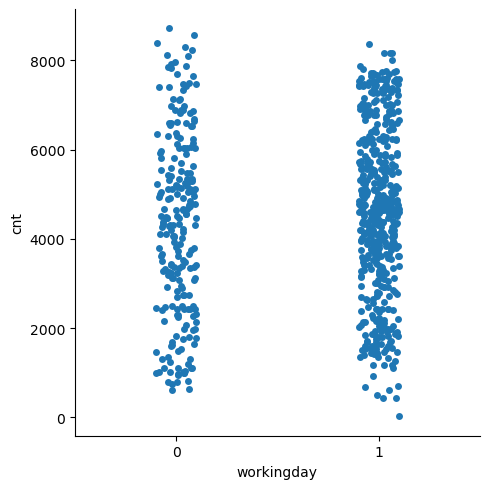

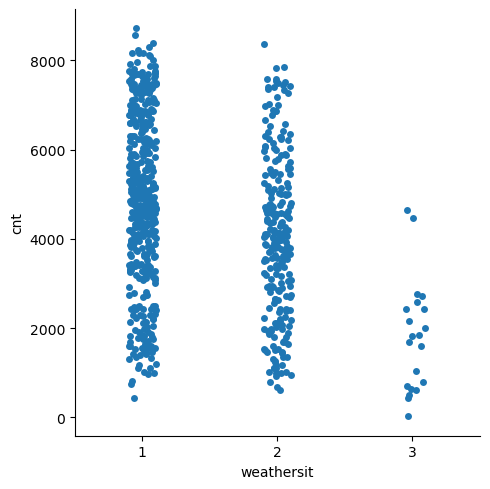

In [29]:
for i in categorical_var:
    sns.catplot(x = i, y = "cnt", data=Data_Day)
   
  

#### It is found that
#### In Season 2, 3 and 4 has the highest count
#### In Year 1 has high count than 0
#### In Months 3 to 10 has got pretty good count
#### On holidays the count is higher compared non-holidays
#### In weekdays, 0 and 6 has the highest count
#### In weather, 1 has the highest count

Text(0.5, 0, 'Windspeed')

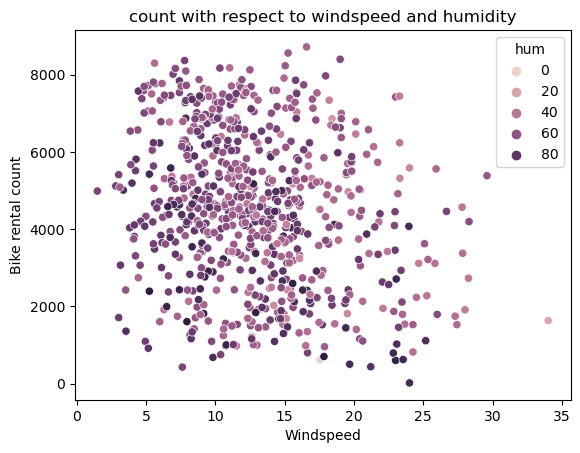

In [31]:
scatter_plot1 = sns.scatterplot(x="windspeed", y="cnt", hue="hum", data= Data_Day)

plt.title("count with respect to windspeed and humidity")
plt.ylabel("Bike rental count")
plt.xlabel("Windspeed")


### count vs windspeed and humidity, Count is High in ranges, windspeed 0.10 to 0.25  and humidity 0.5 to 0.75

Text(0.5, 0, 'Weekdays')

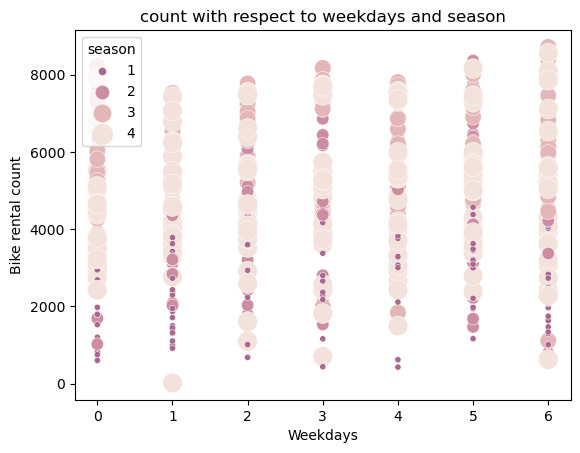

In [33]:
cmap = sns.cubehelix_palette(dark=.9, light=.5, as_cmap=True)

scatter_plot2 = sns.scatterplot(x="weekday", y="cnt",
            hue="season", size="season", sizes = (20, 200), palette=cmap, data= Data_Day)

plt.title("count with respect to weekdays and season")
plt.ylabel("Bike rental count")
plt.xlabel("Weekdays")



### count vs weekdays and season, Count is high in 4th season and 1st and 6th weekdays 

Text(0.5, 0, 'Temperature')

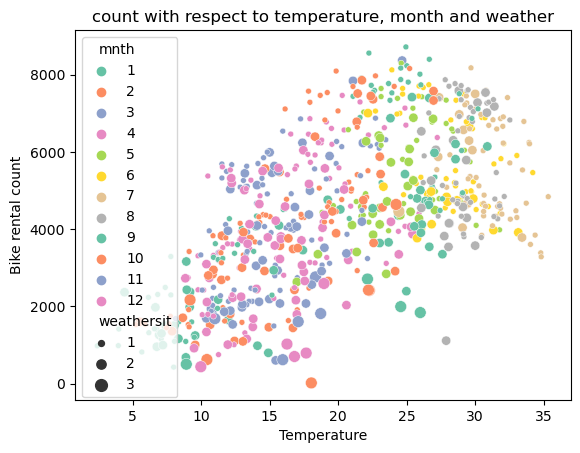

In [35]:
cmap2 = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

scatter_plot3 = sns.scatterplot(x="temp", y="cnt", hue="mnth", size="weathersit", palette="Set2", data=Data_Day)

plt.title("count with respect to temperature, month and weather")
plt.ylabel("Bike rental count")
plt.xlabel("Temperature")



### count vs  temperature, month and weather, Count is high in range temperature 0.5 to 0.8, in 8th month and weather is 0.

Text(0.5, 0, 'Month')

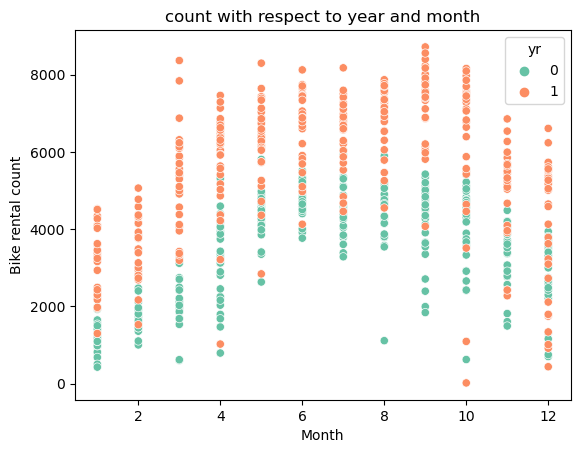

In [37]:
cmap3 = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

scatter_plot4 = sns.scatterplot(x="mnth", y="cnt", hue="yr", palette="Set2", data= Data_Day)

plt.title("count with respect to year and month")
plt.ylabel("Bike rental count")
plt.xlabel("Month")


### count vs respect to year and month, count is high in year 1, particularly from season 3 to 12 excluding 9 

# FEATURE SELECTION

In [40]:
# Correlation Analysis and Anova test to find varaibles which can be excluded

Data_Day_cor = Data_Day.loc[:, numeric_var]
correlation_result = Data_Day_cor.corr()
print(correlation_result)

               temp     atemp       hum  windspeed       cnt
temp       1.000000  0.991696  0.128565  -0.158186  0.627044
atemp      0.991696  1.000000  0.141512  -0.183876  0.630685
hum        0.128565  0.141512  1.000000  -0.248506 -0.098543
windspeed -0.158186 -0.183876 -0.248506   1.000000 -0.235132
cnt        0.627044  0.630685 -0.098543  -0.235132  1.000000


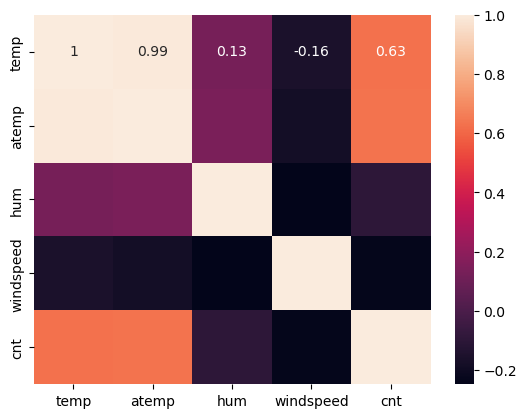

In [41]:
heatmap = sns.heatmap(correlation_result, annot=True)

### It is found that temperature and atemp are highly correlated with each other.

In [43]:
# Anova Test

import statsmodels.api as sm
from statsmodels.formula.api import ols

for i in categorical_var:
    mod = ols('cnt' + '~' + i, data = Data_Day).fit()
    anova_table = sm.stats.anova_lm(mod, typ = 2)
    print(anova_table)

                sum_sq     df           F        PR(>F)
season    4.472604e+08    1.0  142.488566  4.006755e-30
Residual  2.285135e+09  728.0         NaN           NaN
                sum_sq     df           F        PR(>F)
yr        8.869095e+08    1.0  349.864652  4.745374e-64
Residual  1.845485e+09  728.0         NaN           NaN
                sum_sq     df          F        PR(>F)
mnth      2.114606e+08    1.0  61.065968  1.932564e-14
Residual  2.520934e+09  728.0        NaN           NaN
                sum_sq     df         F    PR(>F)
holiday   1.292000e+07    1.0  3.458668  0.063324
Residual  2.719475e+09  728.0       NaN       NaN
                sum_sq     df         F    PR(>F)
weekday   1.246204e+07    1.0  3.335511  0.068209
Residual  2.719933e+09  728.0       NaN       NaN
                  sum_sq     df         F    PR(>F)
workingday  1.068768e+07    1.0  2.858732  0.091307
Residual    2.721707e+09  728.0       NaN       NaN
                  sum_sq     df          F 

### It is found that holiday, weekday and workingday has p value > 0.05, by which, we accept null hypothesis.

In [45]:
#Dimension Reduction

Data_Day = Data_Day.drop(['atemp', 'holiday', 'weekday', 'workingday'], axis = "columns")
print(Data_Day.shape)

(730, 8)


In [46]:
#Final Variables

numeric_var = ["temp","hum","windspeed","cnt"]   # numeric variables

categorical_var = ["season", "yr", "mnth", "weathersit"]   # categorical variables

## FEATURE SCALING

temp


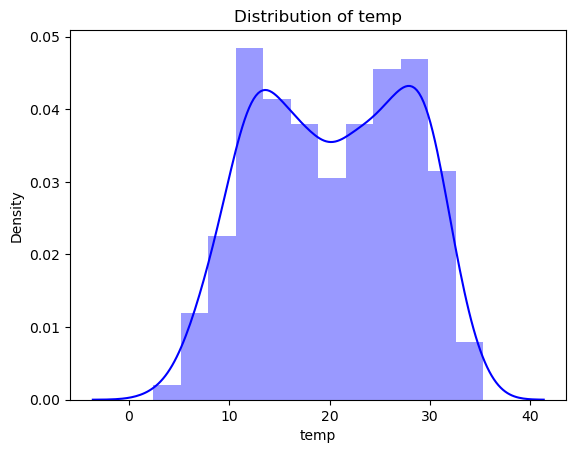

hum


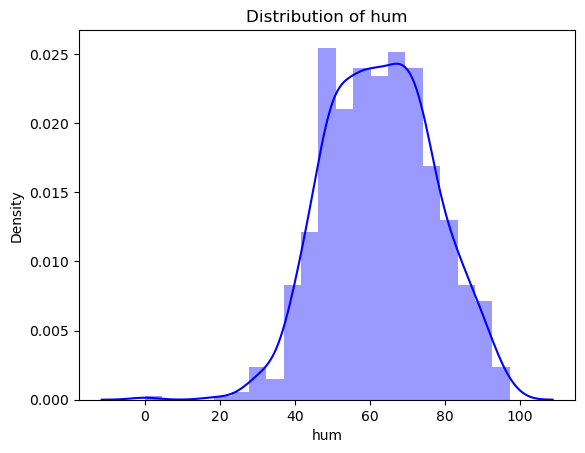

windspeed


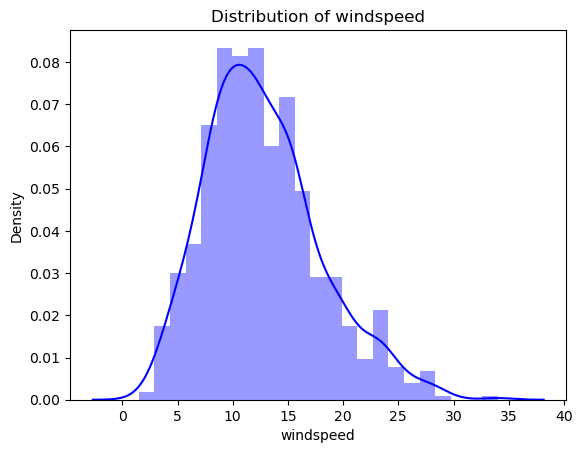

cnt


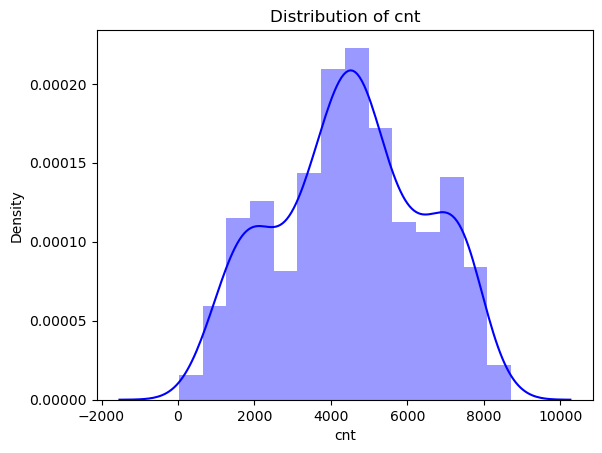

In [48]:
# Check normality 
for i in numeric_var:
    print(i)
    sns.distplot(Data_Day[i], bins = 'auto', color = 'blue')
    plt.title("Distribution of "+i)
    plt.ylabel("Density")
    plt.show()

### distributions are, approximately symmetric

In [50]:
# Check min and max values 

Data_Day.describe()

,season,yr,mnth,weathersit,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,1.394521,20.319259,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.544807,7.506729,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,1.000000,2.424346,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,1.000000,13.811885,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,1.000000,20.465826,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,2.000000,26.880615,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,3.000000,35.328347,97.250000,34.000021,8714.000000


### everything is normalized, no need of scaling

# MODEL DEVELOPMENT

In [53]:
df = Data_Day.copy()
Data_Day = df.copy()

In [54]:
# Create dummy variables

Data_Day = pd.get_dummies(Data_Day, columns = categorical_var) 

Data_Day.shape

(730, 25)

In [55]:
Data_Day.head()

,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,yr_1,...,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_1,weathersit_2,weathersit_3
0,14.110847,80.5833,10.749882,985,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,14.902598,69.6087,16.652113,801,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,8.050924,43.7273,16.636703,1349,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,8.200000,59.0435,10.739832,1562,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,9.305237,43.6957,12.522300,1600,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [56]:
df_for_KFCV = Data_Day

In [57]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr 

In [58]:
#define Error Metrics.

def MAPE(y_actual, y_predicted):
    MAPE = np.mean(np.abs(y_actual-y_predicted)/y_actual)*100
    return MAPE

def Rsquare(y_actual, y_predicted):
    Rsquare = np.corrcoef(y_actual,y_predicted)**2
    return Rsquare

In [59]:
#predictors and target

X = Data_Day.drop(['cnt'], axis = "columns")
y = Data_Day['cnt']

In [60]:
#divide the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)

## DECISION TREE

In [62]:
from sklearn.tree import DecisionTreeRegressor
DTModel = DecisionTreeRegressor(max_depth=2).fit(X_train,y_train)

# Prediction

DTTest = DTModel.predict(X_test)

# MAPE
DTMape_Test = MAPE(y_test, DTTest)


# Rsquare - Test Data

DTR2_Test = Rsquare(y_test, DTTest)

DTR2_Test1 = DTR2_Test.ravel()

DTR2_Test2 = float(DTR2_Test1[1])


print("MAPE ="+str(DTMape_Test))
print("Accuracy =" + str(100 - DTMape_Test))
print("Rsquare ="+str(DTR2_Test2))

MAPE =37.04448570130954
Accuracy =62.95551429869046
Rsquare =0.7180236760820121


In [63]:
DTModel

DecisionTreeRegressor(max_depth=2)

## RANDOM FOREST

In [65]:
from sklearn.ensemble import RandomForestRegressor

RFModel = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)

# Predictions
RFTest = RFModel.predict(X_test)

# MAPE 
RFMape_Test = MAPE(y_test, RFTest)

# Rsquare - Test Data

RFR2_Test = Rsquare(y_test, RFTest)

RFR2_Test1 = RFR2_Test.ravel()

RFR2_Test2 = float(RFR2_Test1[1])

print("MAPE ="+str(RFMape_Test))
print("Accuracy =" + str(100 - RFMape_Test))
print("Rsquare ="+str(RFR2_Test2))

MAPE =21.191740486538137
Accuracy =78.80825951346186
Rsquare =0.8907470776709377


In [66]:
RFModel

RandomForestRegressor()

# LINEAR REGRESSION MODEL

In [69]:
import statsmodels.api as sm
LRModel= sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
print(LRModel.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     137.8
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          8.17e-202
Time:                        23:17:50   Log-Likelihood:                -4716.3
No. Observations:                 584   AIC:                             9475.
Df Residuals:                     563   BIC:                             9566.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
temp           119.3580     11.661     10.236   

In [73]:
#Prediction

LRTest = LRModel.predict(X_test)

#MAPE

LRMape_Test = MAPE(y_test, LRTest)


#Rsquare -Test Data

LRR2_Test = Rsquare(y_test.astype(float), LRTest.astype(float))

LRR2_Test1 = LRR2_Test.ravel()

LRR2_Test2 = float(LRR2_Test1[1])


print("MAPE ="+str(LRMape_Test))
print("Accuracy =" + str(100 - LRMape_Test))
print("Rsquare ="+str(LRR2_Test2))



MAPE =20.14331137716431
Accuracy =79.85668862283569
Rsquare =0.8698892567467649


# KFold Cross Validation

In [76]:
df_for_KFCV.head()

,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,yr_1,...,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_1,weathersit_2,weathersit_3
0,14.110847,80.5833,10.749882,985,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,14.902598,69.6087,16.652113,801,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,8.050924,43.7273,16.636703,1349,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,8.200000,59.0435,10.739832,1562,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,9.305237,43.6957,12.522300,1600,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [78]:
X_kf = df_for_KFCV.drop(['cnt'], axis = "columns")
y_kf = df_for_KFCV['cnt']

In [80]:
X_kf.head()

,temp,hum,windspeed,season_1,season_2,season_3,season_4,yr_0,yr_1,mnth_1,...,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_1,weathersit_2,weathersit_3
0,14.110847,80.5833,10.749882,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
1,14.902598,69.6087,16.652113,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
2,8.050924,43.7273,16.636703,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False
3,8.200000,59.0435,10.739832,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False
4,9.305237,43.6957,12.522300,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False


In [82]:
from sklearn.model_selection import cross_val_score

In [84]:
cross_val_score(DecisionTreeRegressor(max_depth=2), X_kf,y_kf, cv = 3)
#array([ 0.23365401, -0.23313404,  0.15690143])

DT_Score = cross_val_score(DecisionTreeRegressor(max_depth=2), X_kf,y_kf, cv = 3)
np.average(DT_Score)


0.04767287044043703

In [86]:
cross_val_score(RandomForestRegressor(), X_kf,y_kf, cv = 3)
#array([0.69521348, 0.27999794, 0.452253  ])
RF_Score = cross_val_score(RandomForestRegressor(n_estimators = 100), X_kf,y_kf, cv = 3)
np.average(RF_Score)


0.519176599099266

In [87]:
from sklearn.linear_model import LinearRegression
cross_val_score(LinearRegression(), X_kf,y_kf, cv = 3)
#array([0.73477372, 0.6035598 , 0.54577344])

LR_Score = cross_val_score(LinearRegression(), X_kf,y_kf, cv = 3)
np.average(LR_Score)


0.6349306285443868

In [90]:
 ## SAMPLE INPUT OUTPUT

In [92]:
LRModel.predict([[0.4, 0.8, 0.5,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0]])

array([1962.80431064])

In [94]:
#Putting all the variables humidity, weather, temperature , season, month and year,
#it is found that for those particular input we got above result